In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Visualizing an image data set sample

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


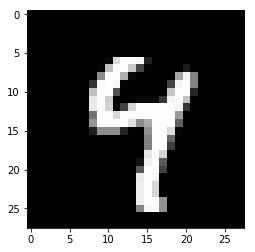

In [3]:
img = mnist.train.images[2]
label = mnist.train.labels[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print(label)


Defining the network 

In [4]:
def conv_net(inputs):
    conv = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)
    
    conv = tf.layers.max_pooling2d(conv,(2,2), (2,2), padding='same')

    conv = tf.layers.conv2d(conv, 64, (5,5), padding='same', activation=tf.nn.relu)

    conv = tf.layers.max_pooling2d(conv,(2,2), (2,2), padding='same')
        
    conv = tf.contrib.layers.flatten(conv)
    
    conv = tf.contrib.layers.fully_connected(conv, 1024, activation_fn=tf.nn.relu)
        
    conv = tf.contrib.layers.fully_connected(conv, 10, activation_fn=None)

    return conv

In [5]:
x = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='x')
y = tf.stop_gradient(tf.placeholder(dtype=tf.float32, shape=[None, 10], name='y'))

logits = conv_net(x)

logits = tf.identity(logits, name='logits')

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Network training hyper parameters

In [11]:
epochs = 70
batch_size = 512

Training network

In [12]:
#Training helper functions    

def train_neural_network(session, optimizer, feature_batch, label_batch):
    session.run(optimizer, feed_dict={
        x: feature_batch,
        y: label_batch
    })
    
def print_training_stats(session, epoch, batch_i, feature_batch, label_batch, validation_feature, validation_label, cost, accuracy):
    loss = sess.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch })
    validation_accuracy = sess.run(accuracy, feed_dict={
                x: validation_feature,
                y: validation_label })
    print('Epoch {:>2}, MNIST Batch {}: Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(epoch + 1, batch_i, loss, validation_accuracy))
    

In [18]:
save_model_path = './numbers_network_model'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables]
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            batch_features = batch[0].reshape((-1, 28, 28, 1))
            batch_labels = batch[1]
            train_neural_network(sess, optimizer, batch_features, batch_labels)
            
            print_training_stats(sess, epoch, i, 
                                 batch_features, batch_labels, 
                                 mnist.validation.images.reshape((-1, 28, 28, 1)), mnist.validation.labels,
                                 cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    tf.train.write_graph(tf.get_default_graph(), './',
                     'mnist_model.pb', as_text=False)
    sess.close()

Training...
Epoch  1, MNIST Batch 0: Loss:     2.3032 Validation Accuracy: 0.081200
Epoch  1, MNIST Batch 1: Loss:     2.3017 Validation Accuracy: 0.088800
Epoch  1, MNIST Batch 2: Loss:     2.3009 Validation Accuracy: 0.094400
Epoch  1, MNIST Batch 3: Loss:     2.2947 Validation Accuracy: 0.100600
Epoch  1, MNIST Batch 4: Loss:     2.2961 Validation Accuracy: 0.106400
Epoch  1, MNIST Batch 5: Loss:     2.2947 Validation Accuracy: 0.113400
Epoch  1, MNIST Batch 6: Loss:     2.2822 Validation Accuracy: 0.117800
Epoch  1, MNIST Batch 7: Loss:     2.2876 Validation Accuracy: 0.120600
Epoch  1, MNIST Batch 8: Loss:     2.2754 Validation Accuracy: 0.123200
Epoch  1, MNIST Batch 9: Loss:     2.2768 Validation Accuracy: 0.127600
Epoch  1, MNIST Batch 10: Loss:     2.2717 Validation Accuracy: 0.131800
Epoch  1, MNIST Batch 11: Loss:     2.2684 Validation Accuracy: 0.137600
Epoch  1, MNIST Batch 12: Loss:     2.2610 Validation Accuracy: 0.140600
Epoch  1, MNIST Batch 13: Loss:     2.2599 Valida

Epoch  2, MNIST Batch 7: Loss:     1.8100 Validation Accuracy: 0.769400
Epoch  2, MNIST Batch 8: Loss:     1.8022 Validation Accuracy: 0.768800
Epoch  2, MNIST Batch 9: Loss:     1.7853 Validation Accuracy: 0.768800
Epoch  2, MNIST Batch 10: Loss:     1.7584 Validation Accuracy: 0.770000
Epoch  2, MNIST Batch 11: Loss:     1.7784 Validation Accuracy: 0.769000
Epoch  2, MNIST Batch 12: Loss:     1.7754 Validation Accuracy: 0.769600
Epoch  2, MNIST Batch 13: Loss:     1.7661 Validation Accuracy: 0.768200
Epoch  2, MNIST Batch 14: Loss:     1.7563 Validation Accuracy: 0.767200
Epoch  2, MNIST Batch 15: Loss:     1.7307 Validation Accuracy: 0.767400
Epoch  2, MNIST Batch 16: Loss:     1.7613 Validation Accuracy: 0.768800
Epoch  2, MNIST Batch 17: Loss:     1.7344 Validation Accuracy: 0.768600
Epoch  2, MNIST Batch 18: Loss:     1.7074 Validation Accuracy: 0.769400
Epoch  2, MNIST Batch 19: Loss:     1.7075 Validation Accuracy: 0.768800
Epoch  2, MNIST Batch 20: Loss:     1.7315 Validation 

Epoch  3, MNIST Batch 14: Loss:     1.0802 Validation Accuracy: 0.817000
Epoch  3, MNIST Batch 15: Loss:     1.0322 Validation Accuracy: 0.818000
Epoch  3, MNIST Batch 16: Loss:     1.0893 Validation Accuracy: 0.819600
Epoch  3, MNIST Batch 17: Loss:     1.0668 Validation Accuracy: 0.820600
Epoch  3, MNIST Batch 18: Loss:     1.0660 Validation Accuracy: 0.821000
Epoch  3, MNIST Batch 19: Loss:     1.0212 Validation Accuracy: 0.821800
Epoch  3, MNIST Batch 20: Loss:     1.0665 Validation Accuracy: 0.822600
Epoch  3, MNIST Batch 21: Loss:     1.0364 Validation Accuracy: 0.822400
Epoch  3, MNIST Batch 22: Loss:     1.0221 Validation Accuracy: 0.823400
Epoch  3, MNIST Batch 23: Loss:     1.0275 Validation Accuracy: 0.824400
Epoch  3, MNIST Batch 24: Loss:     1.0587 Validation Accuracy: 0.823600
Epoch  3, MNIST Batch 25: Loss:     1.0310 Validation Accuracy: 0.823400
Epoch  3, MNIST Batch 26: Loss:     0.9918 Validation Accuracy: 0.823200
Epoch  3, MNIST Batch 27: Loss:     1.0380 Validati

Epoch  4, MNIST Batch 20: Loss:     0.6565 Validation Accuracy: 0.855000
Epoch  4, MNIST Batch 21: Loss:     0.6478 Validation Accuracy: 0.855000
Epoch  4, MNIST Batch 22: Loss:     0.6576 Validation Accuracy: 0.856600
Epoch  4, MNIST Batch 23: Loss:     0.6482 Validation Accuracy: 0.857200
Epoch  4, MNIST Batch 24: Loss:     0.6152 Validation Accuracy: 0.859200
Epoch  4, MNIST Batch 25: Loss:     0.6394 Validation Accuracy: 0.860400
Epoch  4, MNIST Batch 26: Loss:     0.6815 Validation Accuracy: 0.860600
Epoch  4, MNIST Batch 27: Loss:     0.6675 Validation Accuracy: 0.860800
Epoch  4, MNIST Batch 28: Loss:     0.7344 Validation Accuracy: 0.862400
Epoch  4, MNIST Batch 29: Loss:     0.6861 Validation Accuracy: 0.862400
Epoch  4, MNIST Batch 30: Loss:     0.6681 Validation Accuracy: 0.862200
Epoch  4, MNIST Batch 31: Loss:     0.6707 Validation Accuracy: 0.861600
Epoch  4, MNIST Batch 32: Loss:     0.6155 Validation Accuracy: 0.860400
Epoch  4, MNIST Batch 33: Loss:     0.6149 Validati

Epoch  5, MNIST Batch 26: Loss:     0.4838 Validation Accuracy: 0.882600
Epoch  5, MNIST Batch 27: Loss:     0.4880 Validation Accuracy: 0.884400
Epoch  5, MNIST Batch 28: Loss:     0.4730 Validation Accuracy: 0.885200
Epoch  5, MNIST Batch 29: Loss:     0.5038 Validation Accuracy: 0.886200
Epoch  5, MNIST Batch 30: Loss:     0.4886 Validation Accuracy: 0.886000
Epoch  5, MNIST Batch 31: Loss:     0.4897 Validation Accuracy: 0.885600
Epoch  5, MNIST Batch 32: Loss:     0.5676 Validation Accuracy: 0.885400
Epoch  5, MNIST Batch 33: Loss:     0.5076 Validation Accuracy: 0.885800
Epoch  5, MNIST Batch 34: Loss:     0.5457 Validation Accuracy: 0.885400
Epoch  5, MNIST Batch 35: Loss:     0.4985 Validation Accuracy: 0.885600
Epoch  5, MNIST Batch 36: Loss:     0.4961 Validation Accuracy: 0.885400
Epoch  5, MNIST Batch 37: Loss:     0.4971 Validation Accuracy: 0.885800
Epoch  5, MNIST Batch 38: Loss:     0.4970 Validation Accuracy: 0.885600
Epoch  5, MNIST Batch 39: Loss:     0.4892 Validati

Epoch  6, MNIST Batch 33: Loss:     0.4047 Validation Accuracy: 0.904600
Epoch  6, MNIST Batch 34: Loss:     0.4043 Validation Accuracy: 0.905000
Epoch  6, MNIST Batch 35: Loss:     0.4669 Validation Accuracy: 0.905000
Epoch  6, MNIST Batch 36: Loss:     0.4415 Validation Accuracy: 0.904200
Epoch  6, MNIST Batch 37: Loss:     0.4248 Validation Accuracy: 0.903600
Epoch  6, MNIST Batch 38: Loss:     0.4075 Validation Accuracy: 0.904400
Epoch  6, MNIST Batch 39: Loss:     0.4235 Validation Accuracy: 0.905000
Epoch  6, MNIST Batch 40: Loss:     0.4319 Validation Accuracy: 0.904400
Epoch  6, MNIST Batch 41: Loss:     0.4006 Validation Accuracy: 0.904800
Epoch  6, MNIST Batch 42: Loss:     0.3933 Validation Accuracy: 0.905000
Epoch  6, MNIST Batch 43: Loss:     0.4321 Validation Accuracy: 0.905400
Epoch  6, MNIST Batch 44: Loss:     0.4291 Validation Accuracy: 0.905600
Epoch  6, MNIST Batch 45: Loss:     0.3998 Validation Accuracy: 0.904800
Epoch  6, MNIST Batch 46: Loss:     0.3920 Validati

Epoch  7, MNIST Batch 39: Loss:     0.3231 Validation Accuracy: 0.914400
Epoch  7, MNIST Batch 40: Loss:     0.3559 Validation Accuracy: 0.914400
Epoch  7, MNIST Batch 41: Loss:     0.3959 Validation Accuracy: 0.914200
Epoch  7, MNIST Batch 42: Loss:     0.3284 Validation Accuracy: 0.914400
Epoch  7, MNIST Batch 43: Loss:     0.3698 Validation Accuracy: 0.914800
Epoch  7, MNIST Batch 44: Loss:     0.3278 Validation Accuracy: 0.915000
Epoch  7, MNIST Batch 45: Loss:     0.3501 Validation Accuracy: 0.915600
Epoch  7, MNIST Batch 46: Loss:     0.3289 Validation Accuracy: 0.914600
Epoch  7, MNIST Batch 47: Loss:     0.3526 Validation Accuracy: 0.914400
Epoch  7, MNIST Batch 48: Loss:     0.3381 Validation Accuracy: 0.913600
Epoch  7, MNIST Batch 49: Loss:     0.3280 Validation Accuracy: 0.913600
Epoch  7, MNIST Batch 50: Loss:     0.3525 Validation Accuracy: 0.913600
Epoch  7, MNIST Batch 51: Loss:     0.3409 Validation Accuracy: 0.912600
Epoch  7, MNIST Batch 52: Loss:     0.3529 Validati

Epoch  8, MNIST Batch 46: Loss:     0.3115 Validation Accuracy: 0.924000
Epoch  8, MNIST Batch 47: Loss:     0.3135 Validation Accuracy: 0.923600
Epoch  8, MNIST Batch 48: Loss:     0.2930 Validation Accuracy: 0.923000
Epoch  8, MNIST Batch 49: Loss:     0.2793 Validation Accuracy: 0.922400
Epoch  8, MNIST Batch 50: Loss:     0.2834 Validation Accuracy: 0.922200
Epoch  8, MNIST Batch 51: Loss:     0.3277 Validation Accuracy: 0.922600
Epoch  8, MNIST Batch 52: Loss:     0.2793 Validation Accuracy: 0.922200
Epoch  8, MNIST Batch 53: Loss:     0.3191 Validation Accuracy: 0.921800
Epoch  8, MNIST Batch 54: Loss:     0.3422 Validation Accuracy: 0.921600
Epoch  8, MNIST Batch 55: Loss:     0.3332 Validation Accuracy: 0.921400
Epoch  8, MNIST Batch 56: Loss:     0.3391 Validation Accuracy: 0.922200
Epoch  8, MNIST Batch 57: Loss:     0.2666 Validation Accuracy: 0.922200
Epoch  8, MNIST Batch 58: Loss:     0.2802 Validation Accuracy: 0.922600
Epoch  8, MNIST Batch 59: Loss:     0.2630 Validati

Epoch  9, MNIST Batch 52: Loss:     0.3322 Validation Accuracy: 0.926000
Epoch  9, MNIST Batch 53: Loss:     0.3214 Validation Accuracy: 0.926400
Epoch  9, MNIST Batch 54: Loss:     0.2853 Validation Accuracy: 0.927400
Epoch  9, MNIST Batch 55: Loss:     0.3044 Validation Accuracy: 0.927400
Epoch  9, MNIST Batch 56: Loss:     0.3361 Validation Accuracy: 0.928000
Epoch  9, MNIST Batch 57: Loss:     0.2291 Validation Accuracy: 0.927600
Epoch  9, MNIST Batch 58: Loss:     0.3523 Validation Accuracy: 0.926800
Epoch  9, MNIST Batch 59: Loss:     0.2757 Validation Accuracy: 0.926800
Epoch  9, MNIST Batch 60: Loss:     0.2792 Validation Accuracy: 0.926600
Epoch  9, MNIST Batch 61: Loss:     0.2487 Validation Accuracy: 0.926800
Epoch  9, MNIST Batch 62: Loss:     0.2719 Validation Accuracy: 0.927400
Epoch  9, MNIST Batch 63: Loss:     0.2681 Validation Accuracy: 0.928000
Epoch  9, MNIST Batch 64: Loss:     0.2671 Validation Accuracy: 0.928400
Epoch  9, MNIST Batch 65: Loss:     0.2675 Validati

Epoch 10, MNIST Batch 58: Loss:     0.2639 Validation Accuracy: 0.932600
Epoch 10, MNIST Batch 59: Loss:     0.2749 Validation Accuracy: 0.932600
Epoch 10, MNIST Batch 60: Loss:     0.2329 Validation Accuracy: 0.932200
Epoch 10, MNIST Batch 61: Loss:     0.2731 Validation Accuracy: 0.932600
Epoch 10, MNIST Batch 62: Loss:     0.2808 Validation Accuracy: 0.932800
Epoch 10, MNIST Batch 63: Loss:     0.2575 Validation Accuracy: 0.932800
Epoch 10, MNIST Batch 64: Loss:     0.2550 Validation Accuracy: 0.932800
Epoch 10, MNIST Batch 65: Loss:     0.2076 Validation Accuracy: 0.933200
Epoch 10, MNIST Batch 66: Loss:     0.2594 Validation Accuracy: 0.933400
Epoch 10, MNIST Batch 67: Loss:     0.2831 Validation Accuracy: 0.932600
Epoch 10, MNIST Batch 68: Loss:     0.2206 Validation Accuracy: 0.932400
Epoch 10, MNIST Batch 69: Loss:     0.2697 Validation Accuracy: 0.931800
Epoch 10, MNIST Batch 70: Loss:     0.2256 Validation Accuracy: 0.932400
Epoch 10, MNIST Batch 71: Loss:     0.2366 Validati

Epoch 11, MNIST Batch 64: Loss:     0.2650 Validation Accuracy: 0.936000
Epoch 11, MNIST Batch 65: Loss:     0.2694 Validation Accuracy: 0.935800
Epoch 11, MNIST Batch 66: Loss:     0.2584 Validation Accuracy: 0.935800
Epoch 11, MNIST Batch 67: Loss:     0.2004 Validation Accuracy: 0.935600
Epoch 11, MNIST Batch 68: Loss:     0.2599 Validation Accuracy: 0.935000
Epoch 11, MNIST Batch 69: Loss:     0.2231 Validation Accuracy: 0.935800
Epoch 11, MNIST Batch 70: Loss:     0.2459 Validation Accuracy: 0.935600
Epoch 11, MNIST Batch 71: Loss:     0.2165 Validation Accuracy: 0.935200
Epoch 11, MNIST Batch 72: Loss:     0.2450 Validation Accuracy: 0.935400
Epoch 11, MNIST Batch 73: Loss:     0.2620 Validation Accuracy: 0.935400
Epoch 11, MNIST Batch 74: Loss:     0.2355 Validation Accuracy: 0.935200
Epoch 11, MNIST Batch 75: Loss:     0.2684 Validation Accuracy: 0.935200
Epoch 11, MNIST Batch 76: Loss:     0.2516 Validation Accuracy: 0.935400
Epoch 11, MNIST Batch 77: Loss:     0.2815 Validati

Epoch 12, MNIST Batch 71: Loss:     0.2467 Validation Accuracy: 0.939600
Epoch 12, MNIST Batch 72: Loss:     0.2509 Validation Accuracy: 0.939800
Epoch 12, MNIST Batch 73: Loss:     0.2785 Validation Accuracy: 0.940800
Epoch 12, MNIST Batch 74: Loss:     0.2400 Validation Accuracy: 0.940200
Epoch 12, MNIST Batch 75: Loss:     0.2130 Validation Accuracy: 0.940000
Epoch 12, MNIST Batch 76: Loss:     0.2878 Validation Accuracy: 0.940800
Epoch 12, MNIST Batch 77: Loss:     0.2327 Validation Accuracy: 0.940600
Epoch 12, MNIST Batch 78: Loss:     0.2197 Validation Accuracy: 0.942000
Epoch 12, MNIST Batch 79: Loss:     0.2473 Validation Accuracy: 0.942400
Epoch 12, MNIST Batch 80: Loss:     0.2355 Validation Accuracy: 0.942200
Epoch 12, MNIST Batch 81: Loss:     0.3012 Validation Accuracy: 0.941600
Epoch 12, MNIST Batch 82: Loss:     0.2156 Validation Accuracy: 0.941400
Epoch 12, MNIST Batch 83: Loss:     0.2391 Validation Accuracy: 0.940800
Epoch 12, MNIST Batch 84: Loss:     0.1948 Validati

Epoch 13, MNIST Batch 77: Loss:     0.1858 Validation Accuracy: 0.941200
Epoch 13, MNIST Batch 78: Loss:     0.2178 Validation Accuracy: 0.941400
Epoch 13, MNIST Batch 79: Loss:     0.2302 Validation Accuracy: 0.942000
Epoch 13, MNIST Batch 80: Loss:     0.2294 Validation Accuracy: 0.941800
Epoch 13, MNIST Batch 81: Loss:     0.2574 Validation Accuracy: 0.942600
Epoch 13, MNIST Batch 82: Loss:     0.2820 Validation Accuracy: 0.942800
Epoch 13, MNIST Batch 83: Loss:     0.2310 Validation Accuracy: 0.943600
Epoch 13, MNIST Batch 84: Loss:     0.2337 Validation Accuracy: 0.943200
Epoch 13, MNIST Batch 85: Loss:     0.2134 Validation Accuracy: 0.943000
Epoch 13, MNIST Batch 86: Loss:     0.2162 Validation Accuracy: 0.943400
Epoch 13, MNIST Batch 87: Loss:     0.2186 Validation Accuracy: 0.943400
Epoch 13, MNIST Batch 88: Loss:     0.2027 Validation Accuracy: 0.943600
Epoch 13, MNIST Batch 89: Loss:     0.1892 Validation Accuracy: 0.943400
Epoch 13, MNIST Batch 90: Loss:     0.2461 Validati

Epoch 14, MNIST Batch 84: Loss:     0.1894 Validation Accuracy: 0.947000
Epoch 14, MNIST Batch 85: Loss:     0.2285 Validation Accuracy: 0.946600
Epoch 14, MNIST Batch 86: Loss:     0.1746 Validation Accuracy: 0.946600
Epoch 14, MNIST Batch 87: Loss:     0.1961 Validation Accuracy: 0.945800
Epoch 14, MNIST Batch 88: Loss:     0.2162 Validation Accuracy: 0.946000
Epoch 14, MNIST Batch 89: Loss:     0.1972 Validation Accuracy: 0.946400
Epoch 14, MNIST Batch 90: Loss:     0.2478 Validation Accuracy: 0.946000
Epoch 14, MNIST Batch 91: Loss:     0.2036 Validation Accuracy: 0.945200
Epoch 14, MNIST Batch 92: Loss:     0.2150 Validation Accuracy: 0.945600
Epoch 14, MNIST Batch 93: Loss:     0.2207 Validation Accuracy: 0.945800
Epoch 14, MNIST Batch 94: Loss:     0.1815 Validation Accuracy: 0.945800
Epoch 14, MNIST Batch 95: Loss:     0.2029 Validation Accuracy: 0.945600
Epoch 14, MNIST Batch 96: Loss:     0.2316 Validation Accuracy: 0.945200
Epoch 14, MNIST Batch 97: Loss:     0.2463 Validati

Epoch 15, MNIST Batch 90: Loss:     0.1841 Validation Accuracy: 0.950000
Epoch 15, MNIST Batch 91: Loss:     0.1648 Validation Accuracy: 0.949800
Epoch 15, MNIST Batch 92: Loss:     0.2310 Validation Accuracy: 0.949600
Epoch 15, MNIST Batch 93: Loss:     0.1266 Validation Accuracy: 0.949600
Epoch 15, MNIST Batch 94: Loss:     0.1862 Validation Accuracy: 0.949800
Epoch 15, MNIST Batch 95: Loss:     0.1937 Validation Accuracy: 0.949400
Epoch 15, MNIST Batch 96: Loss:     0.2286 Validation Accuracy: 0.949000
Epoch 15, MNIST Batch 97: Loss:     0.2009 Validation Accuracy: 0.949400
Epoch 15, MNIST Batch 98: Loss:     0.3153 Validation Accuracy: 0.949400
Epoch 15, MNIST Batch 99: Loss:     0.1880 Validation Accuracy: 0.949400
Epoch 15, MNIST Batch 100: Loss:     0.1655 Validation Accuracy: 0.949400
Epoch 15, MNIST Batch 101: Loss:     0.1880 Validation Accuracy: 0.949400
Epoch 15, MNIST Batch 102: Loss:     0.2030 Validation Accuracy: 0.949400
Epoch 15, MNIST Batch 103: Loss:     0.1924 Vali

Epoch 16, MNIST Batch 96: Loss:     0.1804 Validation Accuracy: 0.951600
Epoch 16, MNIST Batch 97: Loss:     0.1914 Validation Accuracy: 0.951400
Epoch 16, MNIST Batch 98: Loss:     0.2188 Validation Accuracy: 0.951000
Epoch 16, MNIST Batch 99: Loss:     0.1440 Validation Accuracy: 0.950800
Epoch 16, MNIST Batch 100: Loss:     0.1399 Validation Accuracy: 0.950600
Epoch 16, MNIST Batch 101: Loss:     0.1802 Validation Accuracy: 0.950200
Epoch 16, MNIST Batch 102: Loss:     0.1741 Validation Accuracy: 0.950000
Epoch 16, MNIST Batch 103: Loss:     0.1969 Validation Accuracy: 0.950000
Epoch 16, MNIST Batch 104: Loss:     0.2144 Validation Accuracy: 0.950000
Epoch 16, MNIST Batch 105: Loss:     0.2073 Validation Accuracy: 0.950600
Epoch 16, MNIST Batch 106: Loss:     0.1823 Validation Accuracy: 0.951200
Epoch 17, MNIST Batch 0: Loss:     0.1570 Validation Accuracy: 0.952600
Epoch 17, MNIST Batch 1: Loss:     0.2118 Validation Accuracy: 0.952200
Epoch 17, MNIST Batch 2: Loss:     0.1872 Vali

Epoch 17, MNIST Batch 103: Loss:     0.1707 Validation Accuracy: 0.953800
Epoch 17, MNIST Batch 104: Loss:     0.1828 Validation Accuracy: 0.954200
Epoch 17, MNIST Batch 105: Loss:     0.1250 Validation Accuracy: 0.954400
Epoch 17, MNIST Batch 106: Loss:     0.1990 Validation Accuracy: 0.953800
Epoch 18, MNIST Batch 0: Loss:     0.2290 Validation Accuracy: 0.953600
Epoch 18, MNIST Batch 1: Loss:     0.1878 Validation Accuracy: 0.952800
Epoch 18, MNIST Batch 2: Loss:     0.1464 Validation Accuracy: 0.953600
Epoch 18, MNIST Batch 3: Loss:     0.1906 Validation Accuracy: 0.953600
Epoch 18, MNIST Batch 4: Loss:     0.1796 Validation Accuracy: 0.953200
Epoch 18, MNIST Batch 5: Loss:     0.2114 Validation Accuracy: 0.952800
Epoch 18, MNIST Batch 6: Loss:     0.1774 Validation Accuracy: 0.953000
Epoch 18, MNIST Batch 7: Loss:     0.2352 Validation Accuracy: 0.952800
Epoch 18, MNIST Batch 8: Loss:     0.1678 Validation Accuracy: 0.952600
Epoch 18, MNIST Batch 9: Loss:     0.1722 Validation Acc

Epoch 19, MNIST Batch 2: Loss:     0.1743 Validation Accuracy: 0.957000
Epoch 19, MNIST Batch 3: Loss:     0.1648 Validation Accuracy: 0.957400
Epoch 19, MNIST Batch 4: Loss:     0.2040 Validation Accuracy: 0.957400
Epoch 19, MNIST Batch 5: Loss:     0.1660 Validation Accuracy: 0.956000
Epoch 19, MNIST Batch 6: Loss:     0.1679 Validation Accuracy: 0.955800
Epoch 19, MNIST Batch 7: Loss:     0.1887 Validation Accuracy: 0.955800
Epoch 19, MNIST Batch 8: Loss:     0.1276 Validation Accuracy: 0.956000
Epoch 19, MNIST Batch 9: Loss:     0.1388 Validation Accuracy: 0.955800
Epoch 19, MNIST Batch 10: Loss:     0.1426 Validation Accuracy: 0.955800
Epoch 19, MNIST Batch 11: Loss:     0.1773 Validation Accuracy: 0.956200
Epoch 19, MNIST Batch 12: Loss:     0.1968 Validation Accuracy: 0.955800
Epoch 19, MNIST Batch 13: Loss:     0.1708 Validation Accuracy: 0.955600
Epoch 19, MNIST Batch 14: Loss:     0.2063 Validation Accuracy: 0.956800
Epoch 19, MNIST Batch 15: Loss:     0.1855 Validation Accur

Epoch 20, MNIST Batch 9: Loss:     0.1747 Validation Accuracy: 0.959600
Epoch 20, MNIST Batch 10: Loss:     0.1860 Validation Accuracy: 0.959400
Epoch 20, MNIST Batch 11: Loss:     0.2119 Validation Accuracy: 0.959200
Epoch 20, MNIST Batch 12: Loss:     0.1281 Validation Accuracy: 0.958800
Epoch 20, MNIST Batch 13: Loss:     0.1641 Validation Accuracy: 0.959000
Epoch 20, MNIST Batch 14: Loss:     0.1345 Validation Accuracy: 0.958600
Epoch 20, MNIST Batch 15: Loss:     0.1662 Validation Accuracy: 0.957800
Epoch 20, MNIST Batch 16: Loss:     0.1740 Validation Accuracy: 0.957800
Epoch 20, MNIST Batch 17: Loss:     0.1228 Validation Accuracy: 0.957400
Epoch 20, MNIST Batch 18: Loss:     0.1873 Validation Accuracy: 0.957000
Epoch 20, MNIST Batch 19: Loss:     0.1660 Validation Accuracy: 0.956800
Epoch 20, MNIST Batch 20: Loss:     0.1914 Validation Accuracy: 0.957400
Epoch 20, MNIST Batch 21: Loss:     0.2060 Validation Accuracy: 0.957800
Epoch 20, MNIST Batch 22: Loss:     0.2004 Validatio

Epoch 21, MNIST Batch 15: Loss:     0.1369 Validation Accuracy: 0.959800
Epoch 21, MNIST Batch 16: Loss:     0.1496 Validation Accuracy: 0.959800
Epoch 21, MNIST Batch 17: Loss:     0.1283 Validation Accuracy: 0.960200
Epoch 21, MNIST Batch 18: Loss:     0.1502 Validation Accuracy: 0.960400
Epoch 21, MNIST Batch 19: Loss:     0.1238 Validation Accuracy: 0.960400
Epoch 21, MNIST Batch 20: Loss:     0.1597 Validation Accuracy: 0.960600
Epoch 21, MNIST Batch 21: Loss:     0.1320 Validation Accuracy: 0.960200
Epoch 21, MNIST Batch 22: Loss:     0.1304 Validation Accuracy: 0.960400
Epoch 21, MNIST Batch 23: Loss:     0.1420 Validation Accuracy: 0.960800
Epoch 21, MNIST Batch 24: Loss:     0.1648 Validation Accuracy: 0.960600
Epoch 21, MNIST Batch 25: Loss:     0.1598 Validation Accuracy: 0.960600
Epoch 21, MNIST Batch 26: Loss:     0.1435 Validation Accuracy: 0.960600
Epoch 21, MNIST Batch 27: Loss:     0.1610 Validation Accuracy: 0.960800
Epoch 21, MNIST Batch 28: Loss:     0.1234 Validati

Epoch 22, MNIST Batch 22: Loss:     0.1531 Validation Accuracy: 0.960800
Epoch 22, MNIST Batch 23: Loss:     0.1909 Validation Accuracy: 0.961000
Epoch 22, MNIST Batch 24: Loss:     0.1435 Validation Accuracy: 0.962000
Epoch 22, MNIST Batch 25: Loss:     0.1513 Validation Accuracy: 0.962400
Epoch 22, MNIST Batch 26: Loss:     0.1602 Validation Accuracy: 0.962600
Epoch 22, MNIST Batch 27: Loss:     0.1736 Validation Accuracy: 0.962400
Epoch 22, MNIST Batch 28: Loss:     0.1633 Validation Accuracy: 0.962600
Epoch 22, MNIST Batch 29: Loss:     0.1371 Validation Accuracy: 0.962800
Epoch 22, MNIST Batch 30: Loss:     0.1332 Validation Accuracy: 0.961800
Epoch 22, MNIST Batch 31: Loss:     0.1858 Validation Accuracy: 0.961600
Epoch 22, MNIST Batch 32: Loss:     0.1522 Validation Accuracy: 0.961800
Epoch 22, MNIST Batch 33: Loss:     0.1675 Validation Accuracy: 0.962200
Epoch 22, MNIST Batch 34: Loss:     0.1825 Validation Accuracy: 0.962200
Epoch 22, MNIST Batch 35: Loss:     0.1719 Validati

Epoch 23, MNIST Batch 28: Loss:     0.1594 Validation Accuracy: 0.965000
Epoch 23, MNIST Batch 29: Loss:     0.1155 Validation Accuracy: 0.965200
Epoch 23, MNIST Batch 30: Loss:     0.1605 Validation Accuracy: 0.965000
Epoch 23, MNIST Batch 31: Loss:     0.1549 Validation Accuracy: 0.964600
Epoch 23, MNIST Batch 32: Loss:     0.1089 Validation Accuracy: 0.965200
Epoch 23, MNIST Batch 33: Loss:     0.1250 Validation Accuracy: 0.965200
Epoch 23, MNIST Batch 34: Loss:     0.1153 Validation Accuracy: 0.964600
Epoch 23, MNIST Batch 35: Loss:     0.1741 Validation Accuracy: 0.964400
Epoch 23, MNIST Batch 36: Loss:     0.1518 Validation Accuracy: 0.964600
Epoch 23, MNIST Batch 37: Loss:     0.1471 Validation Accuracy: 0.964800
Epoch 23, MNIST Batch 38: Loss:     0.1971 Validation Accuracy: 0.964800
Epoch 23, MNIST Batch 39: Loss:     0.1699 Validation Accuracy: 0.964600
Epoch 23, MNIST Batch 40: Loss:     0.1036 Validation Accuracy: 0.964400
Epoch 23, MNIST Batch 41: Loss:     0.1213 Validati

Epoch 24, MNIST Batch 34: Loss:     0.1726 Validation Accuracy: 0.966400
Epoch 24, MNIST Batch 35: Loss:     0.1254 Validation Accuracy: 0.966400
Epoch 24, MNIST Batch 36: Loss:     0.1518 Validation Accuracy: 0.966200
Epoch 24, MNIST Batch 37: Loss:     0.1436 Validation Accuracy: 0.966200
Epoch 24, MNIST Batch 38: Loss:     0.1503 Validation Accuracy: 0.965800
Epoch 24, MNIST Batch 39: Loss:     0.1987 Validation Accuracy: 0.966000
Epoch 24, MNIST Batch 40: Loss:     0.1365 Validation Accuracy: 0.965400
Epoch 24, MNIST Batch 41: Loss:     0.1046 Validation Accuracy: 0.965600
Epoch 24, MNIST Batch 42: Loss:     0.1136 Validation Accuracy: 0.965800
Epoch 24, MNIST Batch 43: Loss:     0.1662 Validation Accuracy: 0.965600
Epoch 24, MNIST Batch 44: Loss:     0.1385 Validation Accuracy: 0.966000
Epoch 24, MNIST Batch 45: Loss:     0.1365 Validation Accuracy: 0.966200
Epoch 24, MNIST Batch 46: Loss:     0.1427 Validation Accuracy: 0.965800
Epoch 24, MNIST Batch 47: Loss:     0.1021 Validati

Epoch 25, MNIST Batch 41: Loss:     0.1471 Validation Accuracy: 0.967400
Epoch 25, MNIST Batch 42: Loss:     0.1169 Validation Accuracy: 0.967200
Epoch 25, MNIST Batch 43: Loss:     0.1454 Validation Accuracy: 0.967000
Epoch 25, MNIST Batch 44: Loss:     0.1287 Validation Accuracy: 0.966800
Epoch 25, MNIST Batch 45: Loss:     0.1682 Validation Accuracy: 0.966800
Epoch 25, MNIST Batch 46: Loss:     0.1047 Validation Accuracy: 0.966800
Epoch 25, MNIST Batch 47: Loss:     0.1513 Validation Accuracy: 0.966800
Epoch 25, MNIST Batch 48: Loss:     0.1260 Validation Accuracy: 0.966800
Epoch 25, MNIST Batch 49: Loss:     0.0921 Validation Accuracy: 0.967000
Epoch 25, MNIST Batch 50: Loss:     0.1096 Validation Accuracy: 0.966600
Epoch 25, MNIST Batch 51: Loss:     0.1580 Validation Accuracy: 0.966600
Epoch 25, MNIST Batch 52: Loss:     0.1241 Validation Accuracy: 0.966800
Epoch 25, MNIST Batch 53: Loss:     0.1168 Validation Accuracy: 0.966600
Epoch 25, MNIST Batch 54: Loss:     0.1930 Validati

Epoch 26, MNIST Batch 47: Loss:     0.1269 Validation Accuracy: 0.968200
Epoch 26, MNIST Batch 48: Loss:     0.1397 Validation Accuracy: 0.968200
Epoch 26, MNIST Batch 49: Loss:     0.1227 Validation Accuracy: 0.968200
Epoch 26, MNIST Batch 50: Loss:     0.1391 Validation Accuracy: 0.968000
Epoch 26, MNIST Batch 51: Loss:     0.1057 Validation Accuracy: 0.967600
Epoch 26, MNIST Batch 52: Loss:     0.1111 Validation Accuracy: 0.967400
Epoch 26, MNIST Batch 53: Loss:     0.1161 Validation Accuracy: 0.967200
Epoch 26, MNIST Batch 54: Loss:     0.1298 Validation Accuracy: 0.967200
Epoch 26, MNIST Batch 55: Loss:     0.1106 Validation Accuracy: 0.968200
Epoch 26, MNIST Batch 56: Loss:     0.1170 Validation Accuracy: 0.967600
Epoch 26, MNIST Batch 57: Loss:     0.1439 Validation Accuracy: 0.967600
Epoch 26, MNIST Batch 58: Loss:     0.1469 Validation Accuracy: 0.968000
Epoch 26, MNIST Batch 59: Loss:     0.1156 Validation Accuracy: 0.968200
Epoch 26, MNIST Batch 60: Loss:     0.1066 Validati

Epoch 27, MNIST Batch 54: Loss:     0.1293 Validation Accuracy: 0.968800
Epoch 27, MNIST Batch 55: Loss:     0.1613 Validation Accuracy: 0.969400
Epoch 27, MNIST Batch 56: Loss:     0.1168 Validation Accuracy: 0.969400
Epoch 27, MNIST Batch 57: Loss:     0.0993 Validation Accuracy: 0.969000
Epoch 27, MNIST Batch 58: Loss:     0.1135 Validation Accuracy: 0.969000
Epoch 27, MNIST Batch 59: Loss:     0.1211 Validation Accuracy: 0.969400
Epoch 27, MNIST Batch 60: Loss:     0.0853 Validation Accuracy: 0.969600
Epoch 27, MNIST Batch 61: Loss:     0.1020 Validation Accuracy: 0.970000
Epoch 27, MNIST Batch 62: Loss:     0.1181 Validation Accuracy: 0.969600
Epoch 27, MNIST Batch 63: Loss:     0.1026 Validation Accuracy: 0.969600
Epoch 27, MNIST Batch 64: Loss:     0.0956 Validation Accuracy: 0.969600
Epoch 27, MNIST Batch 65: Loss:     0.1237 Validation Accuracy: 0.969400
Epoch 27, MNIST Batch 66: Loss:     0.1644 Validation Accuracy: 0.969600
Epoch 27, MNIST Batch 67: Loss:     0.0916 Validati

Epoch 28, MNIST Batch 60: Loss:     0.1229 Validation Accuracy: 0.969400
Epoch 28, MNIST Batch 61: Loss:     0.1235 Validation Accuracy: 0.969000
Epoch 28, MNIST Batch 62: Loss:     0.1205 Validation Accuracy: 0.969400
Epoch 28, MNIST Batch 63: Loss:     0.0948 Validation Accuracy: 0.969600
Epoch 28, MNIST Batch 64: Loss:     0.1017 Validation Accuracy: 0.970000
Epoch 28, MNIST Batch 65: Loss:     0.0995 Validation Accuracy: 0.970000
Epoch 28, MNIST Batch 66: Loss:     0.1513 Validation Accuracy: 0.969800
Epoch 28, MNIST Batch 67: Loss:     0.1164 Validation Accuracy: 0.969800
Epoch 28, MNIST Batch 68: Loss:     0.1272 Validation Accuracy: 0.969800
Epoch 28, MNIST Batch 69: Loss:     0.1258 Validation Accuracy: 0.970200
Epoch 28, MNIST Batch 70: Loss:     0.1213 Validation Accuracy: 0.970200
Epoch 28, MNIST Batch 71: Loss:     0.1134 Validation Accuracy: 0.969800
Epoch 28, MNIST Batch 72: Loss:     0.0935 Validation Accuracy: 0.970600
Epoch 28, MNIST Batch 73: Loss:     0.1044 Validati

Epoch 29, MNIST Batch 66: Loss:     0.0997 Validation Accuracy: 0.971000
Epoch 29, MNIST Batch 67: Loss:     0.0866 Validation Accuracy: 0.970800
Epoch 29, MNIST Batch 68: Loss:     0.0732 Validation Accuracy: 0.970600
Epoch 29, MNIST Batch 69: Loss:     0.1391 Validation Accuracy: 0.970600
Epoch 29, MNIST Batch 70: Loss:     0.1411 Validation Accuracy: 0.970600
Epoch 29, MNIST Batch 71: Loss:     0.0929 Validation Accuracy: 0.970600
Epoch 29, MNIST Batch 72: Loss:     0.0956 Validation Accuracy: 0.970800
Epoch 29, MNIST Batch 73: Loss:     0.1266 Validation Accuracy: 0.971000
Epoch 29, MNIST Batch 74: Loss:     0.0976 Validation Accuracy: 0.970600
Epoch 29, MNIST Batch 75: Loss:     0.0921 Validation Accuracy: 0.970800
Epoch 29, MNIST Batch 76: Loss:     0.0794 Validation Accuracy: 0.970600
Epoch 29, MNIST Batch 77: Loss:     0.0860 Validation Accuracy: 0.970200
Epoch 29, MNIST Batch 78: Loss:     0.1139 Validation Accuracy: 0.970400
Epoch 29, MNIST Batch 79: Loss:     0.1034 Validati

Epoch 30, MNIST Batch 72: Loss:     0.1099 Validation Accuracy: 0.971200
Epoch 30, MNIST Batch 73: Loss:     0.1022 Validation Accuracy: 0.971200
Epoch 30, MNIST Batch 74: Loss:     0.1286 Validation Accuracy: 0.971400
Epoch 30, MNIST Batch 75: Loss:     0.1105 Validation Accuracy: 0.971000
Epoch 30, MNIST Batch 76: Loss:     0.0969 Validation Accuracy: 0.971000
Epoch 30, MNIST Batch 77: Loss:     0.1506 Validation Accuracy: 0.971200
Epoch 30, MNIST Batch 78: Loss:     0.0976 Validation Accuracy: 0.970800
Epoch 30, MNIST Batch 79: Loss:     0.1076 Validation Accuracy: 0.971000
Epoch 30, MNIST Batch 80: Loss:     0.1082 Validation Accuracy: 0.971000
Epoch 30, MNIST Batch 81: Loss:     0.1002 Validation Accuracy: 0.971000
Epoch 30, MNIST Batch 82: Loss:     0.1140 Validation Accuracy: 0.971000
Epoch 30, MNIST Batch 83: Loss:     0.0920 Validation Accuracy: 0.970800
Epoch 30, MNIST Batch 84: Loss:     0.1257 Validation Accuracy: 0.971200
Epoch 30, MNIST Batch 85: Loss:     0.1162 Validati

Epoch 31, MNIST Batch 79: Loss:     0.0883 Validation Accuracy: 0.972400
Epoch 31, MNIST Batch 80: Loss:     0.1134 Validation Accuracy: 0.972400
Epoch 31, MNIST Batch 81: Loss:     0.0917 Validation Accuracy: 0.972200
Epoch 31, MNIST Batch 82: Loss:     0.0833 Validation Accuracy: 0.971600
Epoch 31, MNIST Batch 83: Loss:     0.1139 Validation Accuracy: 0.971400
Epoch 31, MNIST Batch 84: Loss:     0.1463 Validation Accuracy: 0.971600
Epoch 31, MNIST Batch 85: Loss:     0.0838 Validation Accuracy: 0.971400
Epoch 31, MNIST Batch 86: Loss:     0.0866 Validation Accuracy: 0.971800
Epoch 31, MNIST Batch 87: Loss:     0.0742 Validation Accuracy: 0.972000
Epoch 31, MNIST Batch 88: Loss:     0.0988 Validation Accuracy: 0.971800
Epoch 31, MNIST Batch 89: Loss:     0.0893 Validation Accuracy: 0.972200
Epoch 31, MNIST Batch 90: Loss:     0.0794 Validation Accuracy: 0.972000
Epoch 31, MNIST Batch 91: Loss:     0.1233 Validation Accuracy: 0.972000
Epoch 31, MNIST Batch 92: Loss:     0.0984 Validati

Epoch 32, MNIST Batch 85: Loss:     0.1069 Validation Accuracy: 0.971800
Epoch 32, MNIST Batch 86: Loss:     0.0961 Validation Accuracy: 0.972000
Epoch 32, MNIST Batch 87: Loss:     0.0736 Validation Accuracy: 0.972000
Epoch 32, MNIST Batch 88: Loss:     0.1313 Validation Accuracy: 0.972000
Epoch 32, MNIST Batch 89: Loss:     0.0635 Validation Accuracy: 0.972000
Epoch 32, MNIST Batch 90: Loss:     0.0938 Validation Accuracy: 0.972400
Epoch 32, MNIST Batch 91: Loss:     0.1462 Validation Accuracy: 0.972800
Epoch 32, MNIST Batch 92: Loss:     0.0954 Validation Accuracy: 0.973000
Epoch 32, MNIST Batch 93: Loss:     0.1062 Validation Accuracy: 0.973200
Epoch 32, MNIST Batch 94: Loss:     0.1199 Validation Accuracy: 0.973000
Epoch 32, MNIST Batch 95: Loss:     0.1014 Validation Accuracy: 0.972800
Epoch 32, MNIST Batch 96: Loss:     0.0929 Validation Accuracy: 0.972600
Epoch 32, MNIST Batch 97: Loss:     0.0646 Validation Accuracy: 0.972800
Epoch 32, MNIST Batch 98: Loss:     0.1139 Validati

Epoch 33, MNIST Batch 92: Loss:     0.1179 Validation Accuracy: 0.973000
Epoch 33, MNIST Batch 93: Loss:     0.0998 Validation Accuracy: 0.973000
Epoch 33, MNIST Batch 94: Loss:     0.0817 Validation Accuracy: 0.973000
Epoch 33, MNIST Batch 95: Loss:     0.1008 Validation Accuracy: 0.973400
Epoch 33, MNIST Batch 96: Loss:     0.0817 Validation Accuracy: 0.973200
Epoch 33, MNIST Batch 97: Loss:     0.0926 Validation Accuracy: 0.973400
Epoch 33, MNIST Batch 98: Loss:     0.0888 Validation Accuracy: 0.973200
Epoch 33, MNIST Batch 99: Loss:     0.1077 Validation Accuracy: 0.973000
Epoch 33, MNIST Batch 100: Loss:     0.1601 Validation Accuracy: 0.973400
Epoch 33, MNIST Batch 101: Loss:     0.0974 Validation Accuracy: 0.973600
Epoch 33, MNIST Batch 102: Loss:     0.0533 Validation Accuracy: 0.973400
Epoch 33, MNIST Batch 103: Loss:     0.1250 Validation Accuracy: 0.973400
Epoch 33, MNIST Batch 104: Loss:     0.0917 Validation Accuracy: 0.973600
Epoch 33, MNIST Batch 105: Loss:     0.1003 Va

Epoch 34, MNIST Batch 98: Loss:     0.0947 Validation Accuracy: 0.973200
Epoch 34, MNIST Batch 99: Loss:     0.1043 Validation Accuracy: 0.973200
Epoch 34, MNIST Batch 100: Loss:     0.0789 Validation Accuracy: 0.973800
Epoch 34, MNIST Batch 101: Loss:     0.0846 Validation Accuracy: 0.974000
Epoch 34, MNIST Batch 102: Loss:     0.0884 Validation Accuracy: 0.974200
Epoch 34, MNIST Batch 103: Loss:     0.1098 Validation Accuracy: 0.975000
Epoch 34, MNIST Batch 104: Loss:     0.1055 Validation Accuracy: 0.974800
Epoch 34, MNIST Batch 105: Loss:     0.0858 Validation Accuracy: 0.974600
Epoch 34, MNIST Batch 106: Loss:     0.0909 Validation Accuracy: 0.974200
Epoch 35, MNIST Batch 0: Loss:     0.0841 Validation Accuracy: 0.974200
Epoch 35, MNIST Batch 1: Loss:     0.0981 Validation Accuracy: 0.974200
Epoch 35, MNIST Batch 2: Loss:     0.0848 Validation Accuracy: 0.973800
Epoch 35, MNIST Batch 3: Loss:     0.1235 Validation Accuracy: 0.973800
Epoch 35, MNIST Batch 4: Loss:     0.0903 Valida

Epoch 35, MNIST Batch 104: Loss:     0.0658 Validation Accuracy: 0.975200
Epoch 35, MNIST Batch 105: Loss:     0.0899 Validation Accuracy: 0.975200
Epoch 35, MNIST Batch 106: Loss:     0.0908 Validation Accuracy: 0.974800
Epoch 36, MNIST Batch 0: Loss:     0.1250 Validation Accuracy: 0.975000
Epoch 36, MNIST Batch 1: Loss:     0.1179 Validation Accuracy: 0.975000
Epoch 36, MNIST Batch 2: Loss:     0.0791 Validation Accuracy: 0.974600
Epoch 36, MNIST Batch 3: Loss:     0.0996 Validation Accuracy: 0.974600
Epoch 36, MNIST Batch 4: Loss:     0.1065 Validation Accuracy: 0.974800
Epoch 36, MNIST Batch 5: Loss:     0.0758 Validation Accuracy: 0.975000
Epoch 36, MNIST Batch 6: Loss:     0.1052 Validation Accuracy: 0.975200
Epoch 36, MNIST Batch 7: Loss:     0.1040 Validation Accuracy: 0.975600
Epoch 36, MNIST Batch 8: Loss:     0.0895 Validation Accuracy: 0.975400
Epoch 36, MNIST Batch 9: Loss:     0.0922 Validation Accuracy: 0.974800
Epoch 36, MNIST Batch 10: Loss:     0.1038 Validation Accu

Epoch 37, MNIST Batch 4: Loss:     0.0969 Validation Accuracy: 0.976000
Epoch 37, MNIST Batch 5: Loss:     0.0927 Validation Accuracy: 0.975600
Epoch 37, MNIST Batch 6: Loss:     0.0812 Validation Accuracy: 0.975800
Epoch 37, MNIST Batch 7: Loss:     0.1013 Validation Accuracy: 0.976000
Epoch 37, MNIST Batch 8: Loss:     0.0811 Validation Accuracy: 0.975600
Epoch 37, MNIST Batch 9: Loss:     0.0749 Validation Accuracy: 0.975000
Epoch 37, MNIST Batch 10: Loss:     0.0746 Validation Accuracy: 0.975000
Epoch 37, MNIST Batch 11: Loss:     0.0737 Validation Accuracy: 0.975600
Epoch 37, MNIST Batch 12: Loss:     0.0844 Validation Accuracy: 0.976000
Epoch 37, MNIST Batch 13: Loss:     0.1201 Validation Accuracy: 0.976000
Epoch 37, MNIST Batch 14: Loss:     0.0984 Validation Accuracy: 0.976000
Epoch 37, MNIST Batch 15: Loss:     0.0843 Validation Accuracy: 0.976400
Epoch 37, MNIST Batch 16: Loss:     0.0991 Validation Accuracy: 0.976600
Epoch 37, MNIST Batch 17: Loss:     0.0898 Validation Acc

Epoch 38, MNIST Batch 10: Loss:     0.0934 Validation Accuracy: 0.976200
Epoch 38, MNIST Batch 11: Loss:     0.0996 Validation Accuracy: 0.976200
Epoch 38, MNIST Batch 12: Loss:     0.1019 Validation Accuracy: 0.976800
Epoch 38, MNIST Batch 13: Loss:     0.0634 Validation Accuracy: 0.976400
Epoch 38, MNIST Batch 14: Loss:     0.0766 Validation Accuracy: 0.976600
Epoch 38, MNIST Batch 15: Loss:     0.1023 Validation Accuracy: 0.976600
Epoch 38, MNIST Batch 16: Loss:     0.0917 Validation Accuracy: 0.976800
Epoch 38, MNIST Batch 17: Loss:     0.0978 Validation Accuracy: 0.976400
Epoch 38, MNIST Batch 18: Loss:     0.0948 Validation Accuracy: 0.976400
Epoch 38, MNIST Batch 19: Loss:     0.0896 Validation Accuracy: 0.976200
Epoch 38, MNIST Batch 20: Loss:     0.0797 Validation Accuracy: 0.976200
Epoch 38, MNIST Batch 21: Loss:     0.0959 Validation Accuracy: 0.976200
Epoch 38, MNIST Batch 22: Loss:     0.0705 Validation Accuracy: 0.976400
Epoch 38, MNIST Batch 23: Loss:     0.0827 Validati

Epoch 39, MNIST Batch 17: Loss:     0.0916 Validation Accuracy: 0.977000
Epoch 39, MNIST Batch 18: Loss:     0.0903 Validation Accuracy: 0.977000
Epoch 39, MNIST Batch 19: Loss:     0.1063 Validation Accuracy: 0.976600
Epoch 39, MNIST Batch 20: Loss:     0.0563 Validation Accuracy: 0.976600
Epoch 39, MNIST Batch 21: Loss:     0.1086 Validation Accuracy: 0.976200
Epoch 39, MNIST Batch 22: Loss:     0.1108 Validation Accuracy: 0.975800
Epoch 39, MNIST Batch 23: Loss:     0.0910 Validation Accuracy: 0.976200
Epoch 39, MNIST Batch 24: Loss:     0.0958 Validation Accuracy: 0.976000
Epoch 39, MNIST Batch 25: Loss:     0.1135 Validation Accuracy: 0.976600
Epoch 39, MNIST Batch 26: Loss:     0.0999 Validation Accuracy: 0.976600
Epoch 39, MNIST Batch 27: Loss:     0.0978 Validation Accuracy: 0.976600
Epoch 39, MNIST Batch 28: Loss:     0.0915 Validation Accuracy: 0.976600
Epoch 39, MNIST Batch 29: Loss:     0.0829 Validation Accuracy: 0.976200
Epoch 39, MNIST Batch 30: Loss:     0.0934 Validati

Epoch 40, MNIST Batch 23: Loss:     0.0846 Validation Accuracy: 0.975600
Epoch 40, MNIST Batch 24: Loss:     0.0535 Validation Accuracy: 0.975800
Epoch 40, MNIST Batch 25: Loss:     0.0617 Validation Accuracy: 0.976200
Epoch 40, MNIST Batch 26: Loss:     0.0829 Validation Accuracy: 0.975800
Epoch 40, MNIST Batch 27: Loss:     0.0756 Validation Accuracy: 0.975800
Epoch 40, MNIST Batch 28: Loss:     0.0793 Validation Accuracy: 0.976000
Epoch 40, MNIST Batch 29: Loss:     0.0547 Validation Accuracy: 0.976200
Epoch 40, MNIST Batch 30: Loss:     0.0920 Validation Accuracy: 0.976200
Epoch 40, MNIST Batch 31: Loss:     0.0801 Validation Accuracy: 0.977000
Epoch 40, MNIST Batch 32: Loss:     0.1017 Validation Accuracy: 0.977200
Epoch 40, MNIST Batch 33: Loss:     0.0756 Validation Accuracy: 0.978000
Epoch 40, MNIST Batch 34: Loss:     0.1078 Validation Accuracy: 0.977800
Epoch 40, MNIST Batch 35: Loss:     0.0886 Validation Accuracy: 0.977600
Epoch 40, MNIST Batch 36: Loss:     0.0921 Validati

Epoch 41, MNIST Batch 30: Loss:     0.0816 Validation Accuracy: 0.978200
Epoch 41, MNIST Batch 31: Loss:     0.0710 Validation Accuracy: 0.978600
Epoch 41, MNIST Batch 32: Loss:     0.0724 Validation Accuracy: 0.978600
Epoch 41, MNIST Batch 33: Loss:     0.0661 Validation Accuracy: 0.978600
Epoch 41, MNIST Batch 34: Loss:     0.0649 Validation Accuracy: 0.978400
Epoch 41, MNIST Batch 35: Loss:     0.0645 Validation Accuracy: 0.978000
Epoch 41, MNIST Batch 36: Loss:     0.1223 Validation Accuracy: 0.977600
Epoch 41, MNIST Batch 37: Loss:     0.0730 Validation Accuracy: 0.977400
Epoch 41, MNIST Batch 38: Loss:     0.0951 Validation Accuracy: 0.977200
Epoch 41, MNIST Batch 39: Loss:     0.0872 Validation Accuracy: 0.977600
Epoch 41, MNIST Batch 40: Loss:     0.0794 Validation Accuracy: 0.977800
Epoch 41, MNIST Batch 41: Loss:     0.0794 Validation Accuracy: 0.977800
Epoch 41, MNIST Batch 42: Loss:     0.0980 Validation Accuracy: 0.977800
Epoch 41, MNIST Batch 43: Loss:     0.0836 Validati

Epoch 42, MNIST Batch 36: Loss:     0.0812 Validation Accuracy: 0.976800
Epoch 42, MNIST Batch 37: Loss:     0.0634 Validation Accuracy: 0.977400
Epoch 42, MNIST Batch 38: Loss:     0.0597 Validation Accuracy: 0.977400
Epoch 42, MNIST Batch 39: Loss:     0.0510 Validation Accuracy: 0.977200
Epoch 42, MNIST Batch 40: Loss:     0.0803 Validation Accuracy: 0.977000
Epoch 42, MNIST Batch 41: Loss:     0.0762 Validation Accuracy: 0.976600
Epoch 42, MNIST Batch 42: Loss:     0.1349 Validation Accuracy: 0.976600
Epoch 42, MNIST Batch 43: Loss:     0.0395 Validation Accuracy: 0.975600
Epoch 42, MNIST Batch 44: Loss:     0.0624 Validation Accuracy: 0.976000
Epoch 42, MNIST Batch 45: Loss:     0.1111 Validation Accuracy: 0.975800
Epoch 42, MNIST Batch 46: Loss:     0.0618 Validation Accuracy: 0.976600
Epoch 42, MNIST Batch 47: Loss:     0.0605 Validation Accuracy: 0.977000
Epoch 42, MNIST Batch 48: Loss:     0.0980 Validation Accuracy: 0.977400
Epoch 42, MNIST Batch 49: Loss:     0.0794 Validati

Epoch 43, MNIST Batch 42: Loss:     0.0531 Validation Accuracy: 0.979000
Epoch 43, MNIST Batch 43: Loss:     0.0704 Validation Accuracy: 0.979000
Epoch 43, MNIST Batch 44: Loss:     0.0738 Validation Accuracy: 0.979000
Epoch 43, MNIST Batch 45: Loss:     0.0573 Validation Accuracy: 0.979000
Epoch 43, MNIST Batch 46: Loss:     0.0711 Validation Accuracy: 0.979000
Epoch 43, MNIST Batch 47: Loss:     0.0520 Validation Accuracy: 0.978800
Epoch 43, MNIST Batch 48: Loss:     0.0654 Validation Accuracy: 0.978600
Epoch 43, MNIST Batch 49: Loss:     0.0947 Validation Accuracy: 0.978600
Epoch 43, MNIST Batch 50: Loss:     0.0865 Validation Accuracy: 0.978200
Epoch 43, MNIST Batch 51: Loss:     0.0668 Validation Accuracy: 0.978000
Epoch 43, MNIST Batch 52: Loss:     0.0730 Validation Accuracy: 0.978400
Epoch 43, MNIST Batch 53: Loss:     0.0826 Validation Accuracy: 0.978200
Epoch 43, MNIST Batch 54: Loss:     0.0781 Validation Accuracy: 0.978000
Epoch 43, MNIST Batch 55: Loss:     0.0955 Validati

Epoch 44, MNIST Batch 49: Loss:     0.0764 Validation Accuracy: 0.978800
Epoch 44, MNIST Batch 50: Loss:     0.0834 Validation Accuracy: 0.978800
Epoch 44, MNIST Batch 51: Loss:     0.0696 Validation Accuracy: 0.978800
Epoch 44, MNIST Batch 52: Loss:     0.0809 Validation Accuracy: 0.979000
Epoch 44, MNIST Batch 53: Loss:     0.0748 Validation Accuracy: 0.979200
Epoch 44, MNIST Batch 54: Loss:     0.0540 Validation Accuracy: 0.978800
Epoch 44, MNIST Batch 55: Loss:     0.0582 Validation Accuracy: 0.978800
Epoch 44, MNIST Batch 56: Loss:     0.0748 Validation Accuracy: 0.978600
Epoch 44, MNIST Batch 57: Loss:     0.0887 Validation Accuracy: 0.979200
Epoch 44, MNIST Batch 58: Loss:     0.0896 Validation Accuracy: 0.979200
Epoch 44, MNIST Batch 59: Loss:     0.0551 Validation Accuracy: 0.979400
Epoch 44, MNIST Batch 60: Loss:     0.0751 Validation Accuracy: 0.979400
Epoch 44, MNIST Batch 61: Loss:     0.0668 Validation Accuracy: 0.980000
Epoch 44, MNIST Batch 62: Loss:     0.0848 Validati

Epoch 45, MNIST Batch 55: Loss:     0.1027 Validation Accuracy: 0.979000
Epoch 45, MNIST Batch 56: Loss:     0.0655 Validation Accuracy: 0.979000
Epoch 45, MNIST Batch 57: Loss:     0.0671 Validation Accuracy: 0.979200
Epoch 45, MNIST Batch 58: Loss:     0.1036 Validation Accuracy: 0.979200
Epoch 45, MNIST Batch 59: Loss:     0.1024 Validation Accuracy: 0.979200
Epoch 45, MNIST Batch 60: Loss:     0.0806 Validation Accuracy: 0.979600
Epoch 45, MNIST Batch 61: Loss:     0.0521 Validation Accuracy: 0.979400
Epoch 45, MNIST Batch 62: Loss:     0.0790 Validation Accuracy: 0.979800
Epoch 45, MNIST Batch 63: Loss:     0.0926 Validation Accuracy: 0.979800
Epoch 45, MNIST Batch 64: Loss:     0.0470 Validation Accuracy: 0.979800
Epoch 45, MNIST Batch 65: Loss:     0.0829 Validation Accuracy: 0.980000
Epoch 45, MNIST Batch 66: Loss:     0.0763 Validation Accuracy: 0.980000
Epoch 45, MNIST Batch 67: Loss:     0.0991 Validation Accuracy: 0.979800
Epoch 45, MNIST Batch 68: Loss:     0.0760 Validati

Epoch 46, MNIST Batch 62: Loss:     0.1012 Validation Accuracy: 0.980000
Epoch 46, MNIST Batch 63: Loss:     0.1136 Validation Accuracy: 0.980000
Epoch 46, MNIST Batch 64: Loss:     0.0823 Validation Accuracy: 0.980400
Epoch 46, MNIST Batch 65: Loss:     0.0741 Validation Accuracy: 0.980200
Epoch 46, MNIST Batch 66: Loss:     0.1073 Validation Accuracy: 0.979800
Epoch 46, MNIST Batch 67: Loss:     0.0683 Validation Accuracy: 0.979600
Epoch 46, MNIST Batch 68: Loss:     0.1000 Validation Accuracy: 0.979600
Epoch 46, MNIST Batch 69: Loss:     0.0517 Validation Accuracy: 0.979400
Epoch 46, MNIST Batch 70: Loss:     0.0683 Validation Accuracy: 0.979600
Epoch 46, MNIST Batch 71: Loss:     0.0645 Validation Accuracy: 0.979600
Epoch 46, MNIST Batch 72: Loss:     0.0690 Validation Accuracy: 0.979800
Epoch 46, MNIST Batch 73: Loss:     0.0571 Validation Accuracy: 0.979800
Epoch 46, MNIST Batch 74: Loss:     0.0783 Validation Accuracy: 0.979600
Epoch 46, MNIST Batch 75: Loss:     0.0739 Validati

Epoch 47, MNIST Batch 68: Loss:     0.0672 Validation Accuracy: 0.980400
Epoch 47, MNIST Batch 69: Loss:     0.0695 Validation Accuracy: 0.980800
Epoch 47, MNIST Batch 70: Loss:     0.0818 Validation Accuracy: 0.980400
Epoch 47, MNIST Batch 71: Loss:     0.0780 Validation Accuracy: 0.980400
Epoch 47, MNIST Batch 72: Loss:     0.0963 Validation Accuracy: 0.980400
Epoch 47, MNIST Batch 73: Loss:     0.0749 Validation Accuracy: 0.979800
Epoch 47, MNIST Batch 74: Loss:     0.0513 Validation Accuracy: 0.980200
Epoch 47, MNIST Batch 75: Loss:     0.0874 Validation Accuracy: 0.980000
Epoch 47, MNIST Batch 76: Loss:     0.0611 Validation Accuracy: 0.980000
Epoch 47, MNIST Batch 77: Loss:     0.0472 Validation Accuracy: 0.979800
Epoch 47, MNIST Batch 78: Loss:     0.0758 Validation Accuracy: 0.979800
Epoch 47, MNIST Batch 79: Loss:     0.0524 Validation Accuracy: 0.980200
Epoch 47, MNIST Batch 80: Loss:     0.0570 Validation Accuracy: 0.980000
Epoch 47, MNIST Batch 81: Loss:     0.0638 Validati

Epoch 48, MNIST Batch 74: Loss:     0.0612 Validation Accuracy: 0.981200
Epoch 48, MNIST Batch 75: Loss:     0.0986 Validation Accuracy: 0.981200
Epoch 48, MNIST Batch 76: Loss:     0.0556 Validation Accuracy: 0.981000
Epoch 48, MNIST Batch 77: Loss:     0.0636 Validation Accuracy: 0.980800
Epoch 48, MNIST Batch 78: Loss:     0.0734 Validation Accuracy: 0.980400
Epoch 48, MNIST Batch 79: Loss:     0.0827 Validation Accuracy: 0.980400
Epoch 48, MNIST Batch 80: Loss:     0.1088 Validation Accuracy: 0.980000
Epoch 48, MNIST Batch 81: Loss:     0.0599 Validation Accuracy: 0.980000
Epoch 48, MNIST Batch 82: Loss:     0.0456 Validation Accuracy: 0.980600
Epoch 48, MNIST Batch 83: Loss:     0.0830 Validation Accuracy: 0.980200
Epoch 48, MNIST Batch 84: Loss:     0.0865 Validation Accuracy: 0.980200
Epoch 48, MNIST Batch 85: Loss:     0.0625 Validation Accuracy: 0.980200
Epoch 48, MNIST Batch 86: Loss:     0.0535 Validation Accuracy: 0.980400
Epoch 48, MNIST Batch 87: Loss:     0.0664 Validati

Epoch 49, MNIST Batch 80: Loss:     0.0644 Validation Accuracy: 0.981800
Epoch 49, MNIST Batch 81: Loss:     0.0713 Validation Accuracy: 0.981200
Epoch 49, MNIST Batch 82: Loss:     0.0968 Validation Accuracy: 0.981200
Epoch 49, MNIST Batch 83: Loss:     0.0592 Validation Accuracy: 0.980600
Epoch 49, MNIST Batch 84: Loss:     0.0906 Validation Accuracy: 0.980600
Epoch 49, MNIST Batch 85: Loss:     0.0471 Validation Accuracy: 0.980600
Epoch 49, MNIST Batch 86: Loss:     0.0515 Validation Accuracy: 0.980800
Epoch 49, MNIST Batch 87: Loss:     0.0696 Validation Accuracy: 0.981000
Epoch 49, MNIST Batch 88: Loss:     0.0643 Validation Accuracy: 0.981000
Epoch 49, MNIST Batch 89: Loss:     0.0729 Validation Accuracy: 0.980800
Epoch 49, MNIST Batch 90: Loss:     0.0937 Validation Accuracy: 0.980400
Epoch 49, MNIST Batch 91: Loss:     0.0680 Validation Accuracy: 0.980400
Epoch 49, MNIST Batch 92: Loss:     0.0616 Validation Accuracy: 0.980600
Epoch 49, MNIST Batch 93: Loss:     0.0577 Validati

Epoch 50, MNIST Batch 87: Loss:     0.0614 Validation Accuracy: 0.981400
Epoch 50, MNIST Batch 88: Loss:     0.0642 Validation Accuracy: 0.981400
Epoch 50, MNIST Batch 89: Loss:     0.0881 Validation Accuracy: 0.981400
Epoch 50, MNIST Batch 90: Loss:     0.0322 Validation Accuracy: 0.981600
Epoch 50, MNIST Batch 91: Loss:     0.0360 Validation Accuracy: 0.981800
Epoch 50, MNIST Batch 92: Loss:     0.0577 Validation Accuracy: 0.981200
Epoch 50, MNIST Batch 93: Loss:     0.0975 Validation Accuracy: 0.981600
Epoch 50, MNIST Batch 94: Loss:     0.0616 Validation Accuracy: 0.981800
Epoch 50, MNIST Batch 95: Loss:     0.0822 Validation Accuracy: 0.981600
Epoch 50, MNIST Batch 96: Loss:     0.0582 Validation Accuracy: 0.982000
Epoch 50, MNIST Batch 97: Loss:     0.0373 Validation Accuracy: 0.982200
Epoch 50, MNIST Batch 98: Loss:     0.0627 Validation Accuracy: 0.982200
Epoch 50, MNIST Batch 99: Loss:     0.0488 Validation Accuracy: 0.982400
Epoch 50, MNIST Batch 100: Loss:     0.0616 Validat

Epoch 51, MNIST Batch 93: Loss:     0.0421 Validation Accuracy: 0.981200
Epoch 51, MNIST Batch 94: Loss:     0.0773 Validation Accuracy: 0.981200
Epoch 51, MNIST Batch 95: Loss:     0.0653 Validation Accuracy: 0.981400
Epoch 51, MNIST Batch 96: Loss:     0.0487 Validation Accuracy: 0.981600
Epoch 51, MNIST Batch 97: Loss:     0.0660 Validation Accuracy: 0.982200
Epoch 51, MNIST Batch 98: Loss:     0.0817 Validation Accuracy: 0.981800
Epoch 51, MNIST Batch 99: Loss:     0.0610 Validation Accuracy: 0.982200
Epoch 51, MNIST Batch 100: Loss:     0.0847 Validation Accuracy: 0.982200
Epoch 51, MNIST Batch 101: Loss:     0.0693 Validation Accuracy: 0.982000
Epoch 51, MNIST Batch 102: Loss:     0.0644 Validation Accuracy: 0.982000
Epoch 51, MNIST Batch 103: Loss:     0.0610 Validation Accuracy: 0.982000
Epoch 51, MNIST Batch 104: Loss:     0.0377 Validation Accuracy: 0.981600
Epoch 51, MNIST Batch 105: Loss:     0.0713 Validation Accuracy: 0.981800
Epoch 51, MNIST Batch 106: Loss:     0.0645 V

Epoch 52, MNIST Batch 100: Loss:     0.0473 Validation Accuracy: 0.982200
Epoch 52, MNIST Batch 101: Loss:     0.0689 Validation Accuracy: 0.982200
Epoch 52, MNIST Batch 102: Loss:     0.0564 Validation Accuracy: 0.981800
Epoch 52, MNIST Batch 103: Loss:     0.0762 Validation Accuracy: 0.981400
Epoch 52, MNIST Batch 104: Loss:     0.0469 Validation Accuracy: 0.981200
Epoch 52, MNIST Batch 105: Loss:     0.0484 Validation Accuracy: 0.981600
Epoch 52, MNIST Batch 106: Loss:     0.0381 Validation Accuracy: 0.981600
Epoch 53, MNIST Batch 0: Loss:     0.0795 Validation Accuracy: 0.981800
Epoch 53, MNIST Batch 1: Loss:     0.0405 Validation Accuracy: 0.981800
Epoch 53, MNIST Batch 2: Loss:     0.0594 Validation Accuracy: 0.981200
Epoch 53, MNIST Batch 3: Loss:     0.0550 Validation Accuracy: 0.980800
Epoch 53, MNIST Batch 4: Loss:     0.0527 Validation Accuracy: 0.980600
Epoch 53, MNIST Batch 5: Loss:     0.0624 Validation Accuracy: 0.980600
Epoch 53, MNIST Batch 6: Loss:     0.0569 Validati

Epoch 53, MNIST Batch 106: Loss:     0.0758 Validation Accuracy: 0.981800
Epoch 54, MNIST Batch 0: Loss:     0.1045 Validation Accuracy: 0.981800
Epoch 54, MNIST Batch 1: Loss:     0.0841 Validation Accuracy: 0.981600
Epoch 54, MNIST Batch 2: Loss:     0.0583 Validation Accuracy: 0.981400
Epoch 54, MNIST Batch 3: Loss:     0.0869 Validation Accuracy: 0.981200
Epoch 54, MNIST Batch 4: Loss:     0.0628 Validation Accuracy: 0.981600
Epoch 54, MNIST Batch 5: Loss:     0.0470 Validation Accuracy: 0.981800
Epoch 54, MNIST Batch 6: Loss:     0.0464 Validation Accuracy: 0.981800
Epoch 54, MNIST Batch 7: Loss:     0.0819 Validation Accuracy: 0.982000
Epoch 54, MNIST Batch 8: Loss:     0.0657 Validation Accuracy: 0.982000
Epoch 54, MNIST Batch 9: Loss:     0.0529 Validation Accuracy: 0.981800
Epoch 54, MNIST Batch 10: Loss:     0.0589 Validation Accuracy: 0.981600
Epoch 54, MNIST Batch 11: Loss:     0.0578 Validation Accuracy: 0.981400
Epoch 54, MNIST Batch 12: Loss:     0.0931 Validation Accura

Epoch 55, MNIST Batch 5: Loss:     0.0441 Validation Accuracy: 0.982800
Epoch 55, MNIST Batch 6: Loss:     0.0951 Validation Accuracy: 0.983200
Epoch 55, MNIST Batch 7: Loss:     0.0511 Validation Accuracy: 0.983000
Epoch 55, MNIST Batch 8: Loss:     0.0335 Validation Accuracy: 0.983000
Epoch 55, MNIST Batch 9: Loss:     0.0664 Validation Accuracy: 0.982800
Epoch 55, MNIST Batch 10: Loss:     0.0424 Validation Accuracy: 0.983200
Epoch 55, MNIST Batch 11: Loss:     0.0695 Validation Accuracy: 0.983000
Epoch 55, MNIST Batch 12: Loss:     0.0803 Validation Accuracy: 0.983000
Epoch 55, MNIST Batch 13: Loss:     0.0643 Validation Accuracy: 0.983000
Epoch 55, MNIST Batch 14: Loss:     0.0859 Validation Accuracy: 0.982800
Epoch 55, MNIST Batch 15: Loss:     0.0895 Validation Accuracy: 0.982600
Epoch 55, MNIST Batch 16: Loss:     0.0558 Validation Accuracy: 0.982800
Epoch 55, MNIST Batch 17: Loss:     0.0581 Validation Accuracy: 0.982600
Epoch 55, MNIST Batch 18: Loss:     0.0531 Validation Ac

Epoch 56, MNIST Batch 12: Loss:     0.0672 Validation Accuracy: 0.981600
Epoch 56, MNIST Batch 13: Loss:     0.0669 Validation Accuracy: 0.982000
Epoch 56, MNIST Batch 14: Loss:     0.0650 Validation Accuracy: 0.982200
Epoch 56, MNIST Batch 15: Loss:     0.0523 Validation Accuracy: 0.982800
Epoch 56, MNIST Batch 16: Loss:     0.0484 Validation Accuracy: 0.982800
Epoch 56, MNIST Batch 17: Loss:     0.0514 Validation Accuracy: 0.982800
Epoch 56, MNIST Batch 18: Loss:     0.0793 Validation Accuracy: 0.982600
Epoch 56, MNIST Batch 19: Loss:     0.0806 Validation Accuracy: 0.982800
Epoch 56, MNIST Batch 20: Loss:     0.0679 Validation Accuracy: 0.982600
Epoch 56, MNIST Batch 21: Loss:     0.0426 Validation Accuracy: 0.982600
Epoch 56, MNIST Batch 22: Loss:     0.0721 Validation Accuracy: 0.982600
Epoch 56, MNIST Batch 23: Loss:     0.0410 Validation Accuracy: 0.982200
Epoch 56, MNIST Batch 24: Loss:     0.0541 Validation Accuracy: 0.982200
Epoch 56, MNIST Batch 25: Loss:     0.0449 Validati

Epoch 57, MNIST Batch 18: Loss:     0.0646 Validation Accuracy: 0.983000
Epoch 57, MNIST Batch 19: Loss:     0.0521 Validation Accuracy: 0.983200
Epoch 57, MNIST Batch 20: Loss:     0.0721 Validation Accuracy: 0.983200
Epoch 57, MNIST Batch 21: Loss:     0.0694 Validation Accuracy: 0.982600
Epoch 57, MNIST Batch 22: Loss:     0.0384 Validation Accuracy: 0.982800
Epoch 57, MNIST Batch 23: Loss:     0.0667 Validation Accuracy: 0.982800
Epoch 57, MNIST Batch 24: Loss:     0.0812 Validation Accuracy: 0.983000
Epoch 57, MNIST Batch 25: Loss:     0.0899 Validation Accuracy: 0.983200
Epoch 57, MNIST Batch 26: Loss:     0.0616 Validation Accuracy: 0.982200
Epoch 57, MNIST Batch 27: Loss:     0.0537 Validation Accuracy: 0.982400
Epoch 57, MNIST Batch 28: Loss:     0.0473 Validation Accuracy: 0.982200
Epoch 57, MNIST Batch 29: Loss:     0.0366 Validation Accuracy: 0.981800
Epoch 57, MNIST Batch 30: Loss:     0.0550 Validation Accuracy: 0.981800
Epoch 57, MNIST Batch 31: Loss:     0.0603 Validati

Epoch 58, MNIST Batch 25: Loss:     0.0648 Validation Accuracy: 0.982600
Epoch 58, MNIST Batch 26: Loss:     0.0398 Validation Accuracy: 0.982800
Epoch 58, MNIST Batch 27: Loss:     0.0541 Validation Accuracy: 0.982800
Epoch 58, MNIST Batch 28: Loss:     0.0401 Validation Accuracy: 0.982600
Epoch 58, MNIST Batch 29: Loss:     0.0537 Validation Accuracy: 0.982800
Epoch 58, MNIST Batch 30: Loss:     0.0674 Validation Accuracy: 0.982800
Epoch 58, MNIST Batch 31: Loss:     0.0473 Validation Accuracy: 0.983000
Epoch 58, MNIST Batch 32: Loss:     0.0488 Validation Accuracy: 0.983200
Epoch 58, MNIST Batch 33: Loss:     0.0281 Validation Accuracy: 0.983200
Epoch 58, MNIST Batch 34: Loss:     0.0548 Validation Accuracy: 0.983800
Epoch 58, MNIST Batch 35: Loss:     0.0827 Validation Accuracy: 0.983800
Epoch 58, MNIST Batch 36: Loss:     0.0628 Validation Accuracy: 0.983800
Epoch 58, MNIST Batch 37: Loss:     0.0669 Validation Accuracy: 0.983200
Epoch 58, MNIST Batch 38: Loss:     0.0545 Validati

Epoch 59, MNIST Batch 31: Loss:     0.0396 Validation Accuracy: 0.983400
Epoch 59, MNIST Batch 32: Loss:     0.0497 Validation Accuracy: 0.983000
Epoch 59, MNIST Batch 33: Loss:     0.0439 Validation Accuracy: 0.982400
Epoch 59, MNIST Batch 34: Loss:     0.0442 Validation Accuracy: 0.982400
Epoch 59, MNIST Batch 35: Loss:     0.0559 Validation Accuracy: 0.982400
Epoch 59, MNIST Batch 36: Loss:     0.0472 Validation Accuracy: 0.982600
Epoch 59, MNIST Batch 37: Loss:     0.0615 Validation Accuracy: 0.982400
Epoch 59, MNIST Batch 38: Loss:     0.0727 Validation Accuracy: 0.982400
Epoch 59, MNIST Batch 39: Loss:     0.0513 Validation Accuracy: 0.982400
Epoch 59, MNIST Batch 40: Loss:     0.0752 Validation Accuracy: 0.982400
Epoch 59, MNIST Batch 41: Loss:     0.0816 Validation Accuracy: 0.982600
Epoch 59, MNIST Batch 42: Loss:     0.0619 Validation Accuracy: 0.982800
Epoch 59, MNIST Batch 43: Loss:     0.0534 Validation Accuracy: 0.982800
Epoch 59, MNIST Batch 44: Loss:     0.0707 Validati

Epoch 60, MNIST Batch 38: Loss:     0.0778 Validation Accuracy: 0.984000
Epoch 60, MNIST Batch 39: Loss:     0.0619 Validation Accuracy: 0.984600
Epoch 60, MNIST Batch 40: Loss:     0.0437 Validation Accuracy: 0.984600
Epoch 60, MNIST Batch 41: Loss:     0.0614 Validation Accuracy: 0.984600
Epoch 60, MNIST Batch 42: Loss:     0.0566 Validation Accuracy: 0.984600
Epoch 60, MNIST Batch 43: Loss:     0.0420 Validation Accuracy: 0.984400
Epoch 60, MNIST Batch 44: Loss:     0.0715 Validation Accuracy: 0.984400
Epoch 60, MNIST Batch 45: Loss:     0.0571 Validation Accuracy: 0.984600
Epoch 60, MNIST Batch 46: Loss:     0.0626 Validation Accuracy: 0.984600
Epoch 60, MNIST Batch 47: Loss:     0.0682 Validation Accuracy: 0.984600
Epoch 60, MNIST Batch 48: Loss:     0.0671 Validation Accuracy: 0.984400
Epoch 60, MNIST Batch 49: Loss:     0.0554 Validation Accuracy: 0.984200
Epoch 60, MNIST Batch 50: Loss:     0.0653 Validation Accuracy: 0.984200
Epoch 60, MNIST Batch 51: Loss:     0.0641 Validati

Epoch 61, MNIST Batch 44: Loss:     0.0445 Validation Accuracy: 0.983600
Epoch 61, MNIST Batch 45: Loss:     0.0383 Validation Accuracy: 0.983200
Epoch 61, MNIST Batch 46: Loss:     0.0321 Validation Accuracy: 0.983000
Epoch 61, MNIST Batch 47: Loss:     0.0612 Validation Accuracy: 0.983600
Epoch 61, MNIST Batch 48: Loss:     0.0821 Validation Accuracy: 0.983600
Epoch 61, MNIST Batch 49: Loss:     0.0556 Validation Accuracy: 0.983600
Epoch 61, MNIST Batch 50: Loss:     0.0393 Validation Accuracy: 0.984000
Epoch 61, MNIST Batch 51: Loss:     0.0709 Validation Accuracy: 0.983600
Epoch 61, MNIST Batch 52: Loss:     0.0638 Validation Accuracy: 0.984400
Epoch 61, MNIST Batch 53: Loss:     0.0733 Validation Accuracy: 0.984800
Epoch 61, MNIST Batch 54: Loss:     0.0623 Validation Accuracy: 0.985000
Epoch 61, MNIST Batch 55: Loss:     0.0530 Validation Accuracy: 0.984400
Epoch 61, MNIST Batch 56: Loss:     0.0414 Validation Accuracy: 0.984600
Epoch 61, MNIST Batch 57: Loss:     0.0520 Validati

Epoch 62, MNIST Batch 50: Loss:     0.0383 Validation Accuracy: 0.983800
Epoch 62, MNIST Batch 51: Loss:     0.0556 Validation Accuracy: 0.983800
Epoch 62, MNIST Batch 52: Loss:     0.0461 Validation Accuracy: 0.984000
Epoch 62, MNIST Batch 53: Loss:     0.0561 Validation Accuracy: 0.984200
Epoch 62, MNIST Batch 54: Loss:     0.0608 Validation Accuracy: 0.983800
Epoch 62, MNIST Batch 55: Loss:     0.0612 Validation Accuracy: 0.983600
Epoch 62, MNIST Batch 56: Loss:     0.0456 Validation Accuracy: 0.983400
Epoch 62, MNIST Batch 57: Loss:     0.0506 Validation Accuracy: 0.983800
Epoch 62, MNIST Batch 58: Loss:     0.0817 Validation Accuracy: 0.983800
Epoch 62, MNIST Batch 59: Loss:     0.0438 Validation Accuracy: 0.983800
Epoch 62, MNIST Batch 60: Loss:     0.0537 Validation Accuracy: 0.984200
Epoch 62, MNIST Batch 61: Loss:     0.0536 Validation Accuracy: 0.984200
Epoch 62, MNIST Batch 62: Loss:     0.0701 Validation Accuracy: 0.984000
Epoch 62, MNIST Batch 63: Loss:     0.0654 Validati

Epoch 63, MNIST Batch 57: Loss:     0.0566 Validation Accuracy: 0.984800
Epoch 63, MNIST Batch 58: Loss:     0.0537 Validation Accuracy: 0.984800
Epoch 63, MNIST Batch 59: Loss:     0.0818 Validation Accuracy: 0.984400
Epoch 63, MNIST Batch 60: Loss:     0.0237 Validation Accuracy: 0.984000
Epoch 63, MNIST Batch 61: Loss:     0.0630 Validation Accuracy: 0.984000
Epoch 63, MNIST Batch 62: Loss:     0.0481 Validation Accuracy: 0.984000
Epoch 63, MNIST Batch 63: Loss:     0.0516 Validation Accuracy: 0.984000
Epoch 63, MNIST Batch 64: Loss:     0.0618 Validation Accuracy: 0.983600
Epoch 63, MNIST Batch 65: Loss:     0.0675 Validation Accuracy: 0.983600
Epoch 63, MNIST Batch 66: Loss:     0.0396 Validation Accuracy: 0.983800
Epoch 63, MNIST Batch 67: Loss:     0.0421 Validation Accuracy: 0.983800
Epoch 63, MNIST Batch 68: Loss:     0.0554 Validation Accuracy: 0.983800
Epoch 63, MNIST Batch 69: Loss:     0.0565 Validation Accuracy: 0.983800
Epoch 63, MNIST Batch 70: Loss:     0.0326 Validati

Epoch 64, MNIST Batch 63: Loss:     0.0492 Validation Accuracy: 0.984800
Epoch 64, MNIST Batch 64: Loss:     0.0628 Validation Accuracy: 0.985000
Epoch 64, MNIST Batch 65: Loss:     0.0550 Validation Accuracy: 0.985400
Epoch 64, MNIST Batch 66: Loss:     0.0447 Validation Accuracy: 0.985200
Epoch 64, MNIST Batch 67: Loss:     0.0766 Validation Accuracy: 0.984400
Epoch 64, MNIST Batch 68: Loss:     0.0638 Validation Accuracy: 0.983600
Epoch 64, MNIST Batch 69: Loss:     0.0341 Validation Accuracy: 0.983600
Epoch 64, MNIST Batch 70: Loss:     0.0377 Validation Accuracy: 0.983200
Epoch 64, MNIST Batch 71: Loss:     0.0468 Validation Accuracy: 0.983200
Epoch 64, MNIST Batch 72: Loss:     0.0488 Validation Accuracy: 0.983400
Epoch 64, MNIST Batch 73: Loss:     0.0392 Validation Accuracy: 0.983400
Epoch 64, MNIST Batch 74: Loss:     0.0450 Validation Accuracy: 0.983400
Epoch 64, MNIST Batch 75: Loss:     0.0467 Validation Accuracy: 0.983200
Epoch 64, MNIST Batch 76: Loss:     0.0681 Validati

Epoch 65, MNIST Batch 70: Loss:     0.0583 Validation Accuracy: 0.983800
Epoch 65, MNIST Batch 71: Loss:     0.0382 Validation Accuracy: 0.983600
Epoch 65, MNIST Batch 72: Loss:     0.0274 Validation Accuracy: 0.983400
Epoch 65, MNIST Batch 73: Loss:     0.0528 Validation Accuracy: 0.983000
Epoch 65, MNIST Batch 74: Loss:     0.0577 Validation Accuracy: 0.983200
Epoch 65, MNIST Batch 75: Loss:     0.0610 Validation Accuracy: 0.982800
Epoch 65, MNIST Batch 76: Loss:     0.0492 Validation Accuracy: 0.983000
Epoch 65, MNIST Batch 77: Loss:     0.0501 Validation Accuracy: 0.982800
Epoch 65, MNIST Batch 78: Loss:     0.0523 Validation Accuracy: 0.982800
Epoch 65, MNIST Batch 79: Loss:     0.0731 Validation Accuracy: 0.983400
Epoch 65, MNIST Batch 80: Loss:     0.0329 Validation Accuracy: 0.983200
Epoch 65, MNIST Batch 81: Loss:     0.0523 Validation Accuracy: 0.983000
Epoch 65, MNIST Batch 82: Loss:     0.0379 Validation Accuracy: 0.983600
Epoch 65, MNIST Batch 83: Loss:     0.0453 Validati

Epoch 66, MNIST Batch 76: Loss:     0.0581 Validation Accuracy: 0.984600
Epoch 66, MNIST Batch 77: Loss:     0.0488 Validation Accuracy: 0.984600
Epoch 66, MNIST Batch 78: Loss:     0.0610 Validation Accuracy: 0.984200
Epoch 66, MNIST Batch 79: Loss:     0.0644 Validation Accuracy: 0.984800
Epoch 66, MNIST Batch 80: Loss:     0.0524 Validation Accuracy: 0.984600
Epoch 66, MNIST Batch 81: Loss:     0.0375 Validation Accuracy: 0.984800
Epoch 66, MNIST Batch 82: Loss:     0.0428 Validation Accuracy: 0.984800
Epoch 66, MNIST Batch 83: Loss:     0.0379 Validation Accuracy: 0.985000
Epoch 66, MNIST Batch 84: Loss:     0.0617 Validation Accuracy: 0.985000
Epoch 66, MNIST Batch 85: Loss:     0.0586 Validation Accuracy: 0.985000
Epoch 66, MNIST Batch 86: Loss:     0.0630 Validation Accuracy: 0.985000
Epoch 66, MNIST Batch 87: Loss:     0.0570 Validation Accuracy: 0.985000
Epoch 66, MNIST Batch 88: Loss:     0.0417 Validation Accuracy: 0.985200
Epoch 66, MNIST Batch 89: Loss:     0.0434 Validati

Epoch 67, MNIST Batch 82: Loss:     0.0468 Validation Accuracy: 0.985000
Epoch 67, MNIST Batch 83: Loss:     0.0997 Validation Accuracy: 0.985200
Epoch 67, MNIST Batch 84: Loss:     0.0620 Validation Accuracy: 0.985400
Epoch 67, MNIST Batch 85: Loss:     0.0523 Validation Accuracy: 0.985800
Epoch 67, MNIST Batch 86: Loss:     0.0327 Validation Accuracy: 0.985800
Epoch 67, MNIST Batch 87: Loss:     0.0494 Validation Accuracy: 0.985400
Epoch 67, MNIST Batch 88: Loss:     0.0676 Validation Accuracy: 0.985000
Epoch 67, MNIST Batch 89: Loss:     0.0422 Validation Accuracy: 0.985000
Epoch 67, MNIST Batch 90: Loss:     0.0308 Validation Accuracy: 0.984800
Epoch 67, MNIST Batch 91: Loss:     0.0641 Validation Accuracy: 0.985400
Epoch 67, MNIST Batch 92: Loss:     0.0487 Validation Accuracy: 0.985200
Epoch 67, MNIST Batch 93: Loss:     0.0373 Validation Accuracy: 0.985000
Epoch 67, MNIST Batch 94: Loss:     0.0685 Validation Accuracy: 0.985000
Epoch 67, MNIST Batch 95: Loss:     0.0424 Validati

Epoch 68, MNIST Batch 88: Loss:     0.0399 Validation Accuracy: 0.984800
Epoch 68, MNIST Batch 89: Loss:     0.0621 Validation Accuracy: 0.984600
Epoch 68, MNIST Batch 90: Loss:     0.0521 Validation Accuracy: 0.985000
Epoch 68, MNIST Batch 91: Loss:     0.0471 Validation Accuracy: 0.985000
Epoch 68, MNIST Batch 92: Loss:     0.0475 Validation Accuracy: 0.985000
Epoch 68, MNIST Batch 93: Loss:     0.0740 Validation Accuracy: 0.984800
Epoch 68, MNIST Batch 94: Loss:     0.0553 Validation Accuracy: 0.984800
Epoch 68, MNIST Batch 95: Loss:     0.0537 Validation Accuracy: 0.984800
Epoch 68, MNIST Batch 96: Loss:     0.0275 Validation Accuracy: 0.984600
Epoch 68, MNIST Batch 97: Loss:     0.0335 Validation Accuracy: 0.984800
Epoch 68, MNIST Batch 98: Loss:     0.0387 Validation Accuracy: 0.985000
Epoch 68, MNIST Batch 99: Loss:     0.0347 Validation Accuracy: 0.985200
Epoch 68, MNIST Batch 100: Loss:     0.0528 Validation Accuracy: 0.985200
Epoch 68, MNIST Batch 101: Loss:     0.0327 Valida

Epoch 69, MNIST Batch 95: Loss:     0.0509 Validation Accuracy: 0.985200
Epoch 69, MNIST Batch 96: Loss:     0.0490 Validation Accuracy: 0.985200
Epoch 69, MNIST Batch 97: Loss:     0.0368 Validation Accuracy: 0.985000
Epoch 69, MNIST Batch 98: Loss:     0.0642 Validation Accuracy: 0.984800
Epoch 69, MNIST Batch 99: Loss:     0.0458 Validation Accuracy: 0.984600
Epoch 69, MNIST Batch 100: Loss:     0.0514 Validation Accuracy: 0.984600
Epoch 69, MNIST Batch 101: Loss:     0.0358 Validation Accuracy: 0.984400
Epoch 69, MNIST Batch 102: Loss:     0.0600 Validation Accuracy: 0.984400
Epoch 69, MNIST Batch 103: Loss:     0.0581 Validation Accuracy: 0.984400
Epoch 69, MNIST Batch 104: Loss:     0.0473 Validation Accuracy: 0.984200
Epoch 69, MNIST Batch 105: Loss:     0.0368 Validation Accuracy: 0.984000
Epoch 69, MNIST Batch 106: Loss:     0.0245 Validation Accuracy: 0.984200
Epoch 70, MNIST Batch 0: Loss:     0.0485 Validation Accuracy: 0.984800
Epoch 70, MNIST Batch 1: Loss:     0.0411 Val

Epoch 70, MNIST Batch 101: Loss:     0.0431 Validation Accuracy: 0.983600
Epoch 70, MNIST Batch 102: Loss:     0.0304 Validation Accuracy: 0.983800
Epoch 70, MNIST Batch 103: Loss:     0.0491 Validation Accuracy: 0.983600
Epoch 70, MNIST Batch 104: Loss:     0.0263 Validation Accuracy: 0.983600
Epoch 70, MNIST Batch 105: Loss:     0.0510 Validation Accuracy: 0.983800
Epoch 70, MNIST Batch 106: Loss:     0.0403 Validation Accuracy: 0.983800


Testing the model predictions

In [19]:
# Testing helpers

def display_image_predictions(features, labels, predictions, n_classes):
   
    label_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=3)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]
        axies[image_i][0].imshow(feature.reshape((feature.shape[0],feature.shape[1])))
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])


INFO:tensorflow:Restoring parameters from ./numbers_network_model
Testing Accuracy: 0.9846833881578947



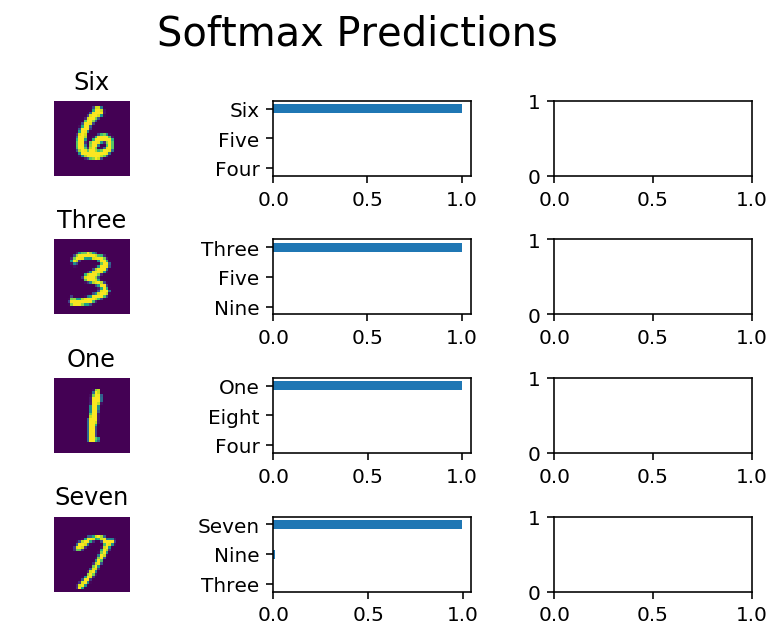

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random

n_samples = 4
top_n_predictions = 3

def test_model():
    
    test_features = mnist.test.images.reshape((-1, 28, 28, 1))
    test_labels = mnist.test.labels
    
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        # Getting Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for i in range(mnist.test.num_examples//batch_size):
            batch = mnist.test.next_batch(batch_size)
            test_feature_batch = batch[0].reshape((-1, 28, 28, 1))
            test_label_batch = batch[1]
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch })
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels })
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, 10)
        sess.close()
test_model()
    